# Trabalho Prático 1 de ICV

´**Autores:** Antônio Caetano Neves Neto e Bernardo Dutra Lemos

O objetivo desse notebook é implementar um método de compressão de imagens com ou sem perdas utilizando Python versão 3.5 
ou superio, no qual deve receber uma imagem de entrada, efetuar sua codificação, salvar o arquivo 
codificado no disco, decodificar o arquivo salvo e mostrar a image  reconstruída, além de apresenta 
o PSNR e a taxa de compressão resultante

O arquivo está separado duas partes:
- **Funções:** definição de métodos auxiliares para a aplicação, como o método Huffman, codificação do header e conteúdo da imagem para o arquivo comprimido, cálculo de entropia e transformações da ordem zigzag
- **Aplicação:** com a leitura de uma imagem em disco, será aplicado a DCT juntamente com métodos de quantização. Após isso, será explorado a redudância interpixel e de codificação da matriz resultante da quantização, podendo comprimir em um arquivo .william. Depois, o arquivo comprimido é lido e transformado na imagem original, e testado a partir de métricas como taxa de compressão e PSNR.s..



## Importações de bibliotecas

In [125]:
import os
import cv2
import PIL
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from PIL import Image
from skimage import data
from scipy import fftpack

## Funções de redundância de codificação

### Huffman

In [28]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

def huffman_encode_by_frequency_table(frequency_table):
    """
        Função responsável por receber a tabela de frequência e retornar a codificação
        análoga de cada símbolo a partir da árvore de huffman, ordenada por profundidade
    """

    # Construção da Fila de Prioridade
    heap = [[wt, [sym, ""]] for sym, wt in frequency_table.items()]
    heapify(heap)
    
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    huffman_table = sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

    return {k: v for k, v in huffman_table}

In [83]:
def huffman_application(frequency_table, npixels, verbose=True):
    """
        Aplica Huffman na tabela de frequência e retorna os dados que a codificação
        obteve, como o número de bits final e o bits por pixel, além da tabela de 
        codificação resultante
    """
    huffman_table = huffman_encode_by_frequency_table(frequency_table)

    if verbose: print ("Símbolo\tPeso\tCódigo de Huffman")
    nbits = 0
    
    for i, element in enumerate(huffman_table):
        if i < 20 and verbose:
            print("%s\t%d\t%s" % (element, frequency_table[element], huffman_table[element]))
        nbits += frequency_table[element]*len(huffman_table[element])
    
    if verbose: print("...")
    
    return nbits, nbits/npixels, huffman_table

In [5]:
def huffman_get_frequency_table(image):
    """
        Com a imagem como parâmetro, transforma ela na tabela de frequência para
        uso futuro no Huffman
    """
    
    freq = {}
    for arr in image:
        for v in arr:
          v = str(v)
          try:
              freq[v] += 1
          except KeyError:
              freq[v] = 1
    return freq

## Funções de redundância interpixel

In [10]:
import numpy as np

def matrix_to_zigzag_order(matrix):
    """
        Somente com matriz 8x8, transforma ela na forma de zigzag estabelecida
        para aumentar a eficácia da preditiva sem perdas
    """
    rows, cols = matrix.shape

    if rows != 8 or cols != 8:
        raise ValueError("A matriz deve ser 8x8 para a ordenação zigzag.")

    # Vetor para armazenar os valores na ordem zigzag
    zigzag = []

    # Inicia o percurso no canto superior esquerdo
    row, col = 0, 0

    # Flag para inverter a direção do percurso
    going_up = True

    for _ in range(8 * 8):
        zigzag.append(matrix[row, col])

        if going_up:
            if col == 7:
                row += 1
                going_up = False
            elif row == 0:
                col += 1
                going_up = False
            else:
                row -= 1
                col += 1
        else:
            if row == 7:
                col += 1
                going_up = True
            elif col == 0:
                row += 1
                going_up = True
            else:
                row += 1
                col -= 1

    # Cria uma lista única com todos os valores ordenados em zigzag
    return np.array(zigzag).flatten().tolist()

In [11]:
import numpy as np

def zigzag_order_to_matrix(zigzag_vector):
    """
        Com o vetor ordenado em zigzag, de tamanho obrigatoriamente 64, transforma na
        matriz 8x8 original.
    """

    if len(zigzag_vector) != 64:
        raise ValueError("O vetor deve ter 64 elementos para a inversa da ordenação zigzag.")
    
    matrix = np.zeros((8, 8))

    # Inicializa as variáveis de posição na matriz
    row, col = 0, 0

    # Flag para inverter a direção do percurso
    going_up = True

    # Percorre o vetor zigzag e preenche a matriz
    for valor in zigzag_vector:
        matrix[row, col] = valor

        if going_up:
            if col == 7:
                row += 1
                going_up = False
            elif row == 0:
                col += 1
                going_up = False
            else:
                row -= 1
                col += 1
        else:
            if row == 7:
                col += 1
                going_up = True
            elif col == 0:
                row += 1
                going_up = True
            else:
                row += 1
                col -= 1

    return matrix

In [13]:
def last_non_zero_occurrence(arr):
    """
        Para qualquer vetor (isso a ser utilizado no zigzag), retorna
        a última ocorrência não zero, visando eliminar os coeficientes
    """
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] != 0:
            return i
            
    # Retorna -1 se não houver nenhum número diferente de zero no array
    return -1  


## Funções para a escrita do arquivo binário

In [7]:
# Separador padrão a ser utilizado para cada conjunto da tabela de Huffman no arquivo .william
separator_table = "|"

def create_header_bits(shape, table):
    """
        Função que com a tabela de frequência final, padroniza de forma a ser salva, com os
        bits representativos original, no header do arquivo .william
    """
    
    # Salva o tamanho da imagem como os dois primeiros números do arquivo
    bits = f"{shape[0]}{separator_table}{shape[1]}{separator_table}"
    
    for k, v in table.items():
        bits += str(k) + ":" + str(v) + separator_table
    
    return bits.encode()

In [9]:
def create_image_bits(huffman_table, img):
    """
        Com a imagem já processada depois da ordenação zig-zag, transforma os valores
        em seus respectivos na tabela Huffman e salva os bits resultantes em forma
        codificada.
    """
    
    bits = str()
    
    for arr in img:
        for v in arr:
            bits += huffman_table[str(v)]

    # Transforma a string de 0s e 1s na forma codificada
    binary_bytes = bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))
    
    return binary_bytes, bits

## Funções de transformadas

In [15]:
JPEG_M = np.matrix([
                [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]
])

JPEG_M = JPEG_M.astype(float)

In [14]:
def dct_more_quantization(image, gs = 8):
    """
        Com a matriz de pixels da imagem, aplica a redução numérica de 128, a transformada discreta 
        do cosseno e, no final, a divisão da matriz de quantização utilizada pelo JPEG, para valorizar
        os coeficientes de frequência baixa
    """
    
    n = np.size(image,0)
    m = np.size(image,1)

    matrix = np.zeros((n, m), dtype=float)

    image = image - 128

    for i in range(0, n, gs):
        for j in range(0, m, gs):
            # Aplicando a DCT nas duas dimensões da imagem
            matrix[i:i+gs, j:j+gs] = fftpack.dct(fftpack.dct(image[i:i+gs, j:j+gs], axis=0, norm='ortho'), axis=1, norm="ortho")

            # Aplicando a quantização, dividindo a matriz resultante da DCT pela da JPEG
            matrix[i:i+gs, j:j+gs] = np.divide(matrix[i:i+gs, j:j+gs], JPEG_M)

    # Retorna uma matriz de inteiros, para uso futuro no Huffman
    return np.int16(matrix.round())

In [16]:
def inverse_dct(dct_matrix, groupSize = 8):
    """
        Com a matriz quantizada da DCT, aplica a multiplicação da matriz JPEG, a inversa da
        transformada discreta do cosseno e, no final, soma novamente os 128 que foram reduzidos
        no início da compressão.
    """
    n = np.size(dct_matrix,0)
    m = np.size(dct_matrix,1)

    matrix = np.zeros((n, m), dtype=float)

    for i in range(0, n, groupSize):
        for j in range(0, m, groupSize):
            # Voltando as valores "originais" da transformada, multiplicando pela matriz JPEG
            matrix[i:i+groupSize, j:j+groupSize] = np.multiply(dct_matrix[i:i+groupSize, j:j+groupSize], JPEG_M)

            # Aplicando a inversa da DCT nas duas dimensões da imagem
            matrix[i:i+groupSize, j:j+groupSize] = fftpack.idct(fftpack.idct(matrix[i:i+groupSize, j:j+groupSize], axis=0, norm='ortho'), axis=1, norm="ortho")

    # Volta com a adição numérica de 128, que foi retirada na função de DCT
    return matrix + 128

## Funções auxiliares

In [18]:
def entropy(img):
    """
        Dado uma matriz de inteiros recebida, calcula a entropia da imagem.
    """
    img = img.astype(np.float32)
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    ent = -1 * (hist*logs).sum()

    return ent

## Aplicação

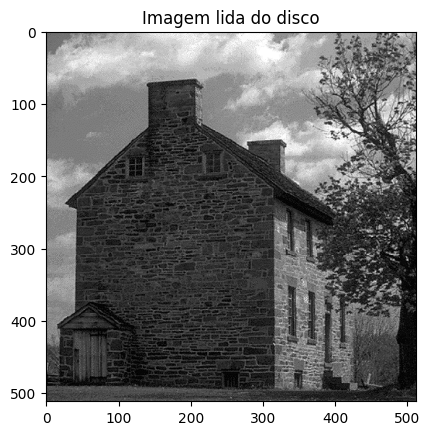

In [171]:
# Importando imagem

# Defina o caminho da imagem aqui.
image_filename = "home.png"
image = np.array(Image.open(image_filename).convert("L")).astype(float)

# Forma de leitura direta com imagem salva do skleark
# image = data.camera()
# image = np.array(image).astype(float)

if image.shape[0] % 8 != 0 or image.shape[1] % 8 != 0:
    raise Exception("A matriz deve ser múltipla de 8 nas duas dimensões.")
    
# Imprimindo a imagem
plt.imshow(image, cmap='gray')
plt.title("Imagem lida do disco")
plt.show()

In [149]:
# Definição de parâmetros
group_size = 8

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [172]:
# Aplicando transformadas
quantized_image = dct_more_quantization(image, group_size)

# Essa decompressão direta servirá de controle para verificar a eficácia da compressão
# do arquivo binário
direct_decompress_image = inverse_dct(quantized_image, group_size)

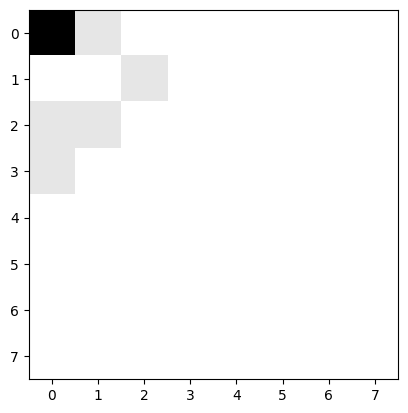

In [174]:
# Como fica um bloco da imagem após a quantização
plt.imshow(quantized_image[0:8,0:8], cmap='gray')
plt.show()

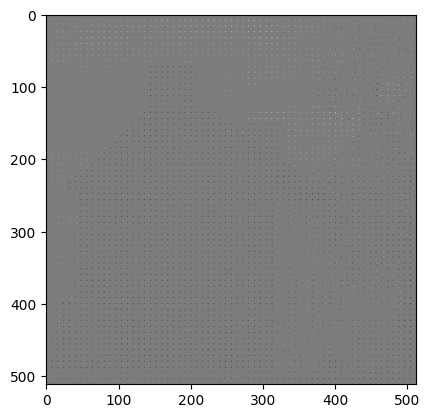

In [175]:
# Imagem após a quantização
plt.imshow(quantized_image, cmap='gray')

In [176]:
# Aplicando a ordenação zigzag em cada bloco 8x8 da matriz
# quando chegar na última ocorrência não zero do bloco, adiciona
# o marcador EOB = end of block

zigzag_image = []
for i in range(0, quantized_image.shape[0], 8):
    for j in range(0, quantized_image.shape[1],8):
        
        x = matrix_to_zigzag_order(quantized_image[i:i+8, j:j+8])
        last = last_non_zero_occurrence(x)
        
        if(last != -1):
            x = [v for v in x[:last+1]]
        x += ['EOB']
        zigzag_image.append(x)

In [177]:
# Criação do arquivo .william
frequency_table = huffman_get_frequency_table(zigzag_image)

# Informações sobre a codificação do Huffman
nbits, bpp, huffman_table = huffman_application(frequency_table, quantized_image.size)

print("\n\nInformações sobre a aplicação da codificação Huffman\n")
print("Entropia original\tBits totais\tBits por pixel\t\tEficiência da codificação")
print("%f\t\t%d\t\t%f\t\t%f" % (entropy(quantized_image), nbits, bpp, entropy(quantized_image) / bpp))

# Codificando as informações finais
header = create_header_bits(quantized_image.shape, frequency_table)
enconde_image, bit = create_image_bits(huffman_table, zigzag_image)

# Separador para na hora de descomprimir, conseguir separar o header da imagem
context_separator = "]"

compressed_file = header + context_separator.encode() + enconde_image
compressed_filename = "compressed.william"

# Salvando o arquivo binário comprimido na extensão pré-definida
with open(compressed_filename, "wb") as file:
  file.write(compressed_file)

Símbolo	Peso	Código de Huffman
0	64658	0
-1	18565	101
1	18674	110
-2	5306	11110
2	5371	11111
3	2684	10000
EOB	4096	10011
-3	2609	111010
-4	1516	100010
4	1689	100100
-5	941	1110000
5	992	1110001
-6	584	11100111
-7	468	10010111
6	715	11101111
7	452	10010101
-10	189	100011001
-40	195	100011010
-8	300	111011001
-9	229	100101100
...


Informações sobre a aplicação da codificação Huffman

Entropia original	Bits totais	Bits por pixel		Eficiência da codificação
0.928190		393000		1.499176		0.619133


In [178]:
# Lendo de volta o arquivo comprimido .william
with open(compressed_filename, "rb") as file:
  code = file.read()

# Separando o arquivo nas duas partes codificada, o header e a imagem
for i in range(0,len(code)):
  if code[i] == ord(context_separator):
    str_header = str(code[0:i])
    str_img = code[i+1:]
    break

# Adquirindo as informações de tamanho da imagem
width, height = [int(v.replace("b'", "")) for v in str_header.split(separator_table, 2)[:2]]

str_table = str_header.split(separator_table, 2)[2]

# Formatando a tabela de frequências
decompress_frequency_table = {str(k): int(v) for k, v in (line.split(":") for line in str_table.split(separator_table)[:-1])}

In [179]:
# Transformando a string salva, que está ordenada em zigzag, para blocos 8x8
represent = ""
_, _, decompress_huffman_table = huffman_application(decompress_frequency_table, width*height, verbose=False)

inverse_huffman_table = {v: k for k, v in decompress_huffman_table.items()}

values = inverse_huffman_table.keys()
blocks = []
block = []

for b in bit:
    # Aplicando a propriedade de representações não são prefixos de outras
    if represent in values:
        
        element = inverse_huffman_table[represent]
        if element == "EOB":
            # Preenchendo o restante com zeros e transformando de volta para matriz
            block += [0]*(64-len(block))
            blocks.append(zigzag_order_to_matrix(np.array(block)))
            block = []
        else:
            block.append(int(element))
    
        represent = ""
    represent += b

In [180]:
# Transformando os blocos 8x8 na imagem original
compressed_image = np.zeros((width, height))

for i, block in enumerate(blocks):
    for j, arr in enumerate(block):
        for k, v in enumerate(arr):
            lin = 8*int(i*8/width) + j
            col = int(8*(i%(width/8)) + k)
    
            compressed_image[lin, col] = v

In [181]:
# Número de casas em que os valores se diferem na compressão
width*height - (compressed_image == quantized_image).sum()

13

In [182]:
# Aplicando a descompressão
decompressed_image = inverse_dct(compressed_image, group_size)

In [183]:
# Número de casas em que os valores se diferem na descompressão
width*height - (decompressed_image == direct_decompress_image).sum()

64

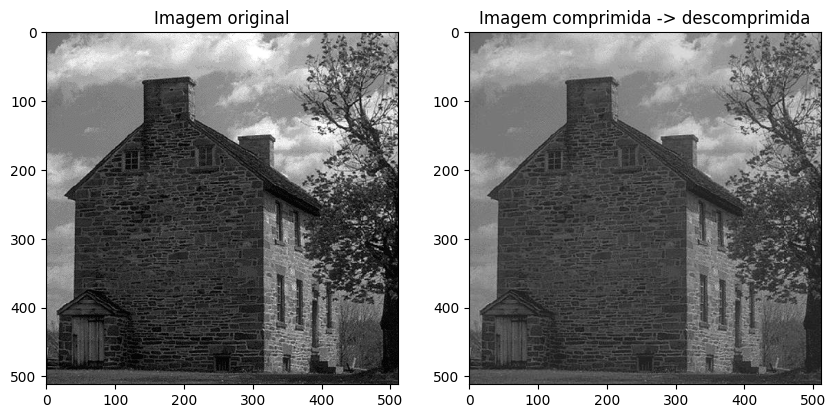

In [184]:
# Plot das duas imagens
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Imagem original")
fig.add_subplot(1, 2, 2)
plt.imshow(direct_decompress_image, cmap='gray')
plt.title("Imagem comprimida -> descomprimida")
plt.show()

In [185]:
# Salvando as imagems para analisar as taxas de compressão
plt.imsave('decompressed_image.png', decompressed_image, cmap='gray')
# plt.imsave(image_filename, image, cmap='gray')

In [186]:
# Calculando o quanto de coeficientes zero a DCT resultou
frac_nonzero = np.sum(np.abs(compressed_image) != 0.0)/compressed_image.size
print("Mantendo %.2f%% dos coeficientes da DCT"%(100*frac_nonzero))

# Taxa de compressão
compressed_size = os.path.getsize(compressed_filename)
decompressed_size = os.path.getsize("decompressed_image.png")
original_size = os.path.getsize(image_filename)

print('Taxa de compressão: %.1f:1'%(original_size/compressed_size))

# Calculando o MSE e o PSNR da imagem descomprimida em relação a original
MSE = np.sum((image-decompressed_image)**2)/image.size
PSNR = 10*np.log10(np.max(image)**2/MSE)
print('MSE: %.2f'%MSE)
print('PSNR: %.2f'%PSNR)

Mantendo 25.40% dos coeficientes da DCT
Taxa de compressão: 6.0:1
MSE: 141.76
PSNR: 26.62
